# OSMNX learning
Maybe an easier method than using Overpy because it natively creates geodataframes

In [1]:
import pandas as pd
import requests
import json
import geopandas as gpd
import contextily as cx
import geopy.distance
from shapely.geometry import MultiPolygon, Polygon, Point, LineString
import osmnx as ox
import pyproj
import geopy.distance
import matplotlib.patches as patches

from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import warnings
# Suppress FutureWarning messages
warnings.simplefilter('ignore', DeprecationWarning)


In [2]:
# Load nation lakes coords   
with open("nation_lakes.json") as f:
    lakes = json.load(f)
print("\nlakes:")
for i,lake in enumerate(lakes):
    print(i,lake["name"])


lakes:
0 Tsayta Lake
1 Indata Lake
2 Tchentlo Lake
3 Chuchi Lake


In [3]:
place = lakes[1]
place_name = place["name"].replace(" ", "-")
print(place)
corners = (place["south"],place["west"],place["north"],place["east"])

desired_tags = {
    'leisure': ['park','nature_reserve'],
    'tourism': ['camp_site'],
    'natural': ['peak', 'mountain_range', 'volcano', 'spring'],
    'highway': ['motorway', 'trunk','primary','secondary','tertiary','unclassified','track','road','path', 'footway'],
    'water':['lake', 'river'],
    'barrier': ['yes']
}

{'name': 'Indata Lake', 'north': 55.3925, 'west': -125.33, 'south': 55.292, 'east': -125.2175, 'lat': 55.34225, 'lon': -125.26875}


In [4]:
gdf = ox.features.features_from_bbox(place["north"], place["south"], place["east"], place["west"], desired_tags)
gdf = gdf.to_crs(epsg=3857) # project to spherical mercator to match tiles
gdf.reset_index(inplace=True)
cols_to_keep = ['element_type', 'geometry', 'name'] + [key for key in desired_tags.keys() if key in gdf.columns]
gdf = gdf[cols_to_keep]
gdf

,element_type,geometry,name,leisure,tourism,natural,highway,water
0,node,POINT (-13942389.851 7423576.131),NaN,NaN,camp_site,NaN,NaN,NaN
1,node,POINT (-13943445.037 7424770.467),Limestone,NaN,camp_site,NaN,NaN,NaN
2,node,POINT (-13943658.225 7430483.231),Indata,NaN,camp_site,NaN,NaN,NaN
3,node,POINT (-13944078.634 7431569.769),NaN,NaN,camp_site,NaN,NaN,NaN
4,node,POINT (-13942544.729 7436774.488),Swannell Ranges,NaN,NaN,peak,NaN,NaN
5,node,POINT (-13950186.913 7433356.461),Limestone Ridge,NaN,NaN,peak,NaN,NaN
6,way,"LINESTRING (-13970322.571 7435109.828, -139703...",Driftwood Forest Service Road,NaN,NaN,NaN,tertiary,NaN
7,way,"LINESTRING (-13951158.075 7419797.951, -139512...",Nesabut Forest Service Road,NaN,NaN,NaN,unclassified,NaN
8,way,"POLYGON ((-13952524.667 7444603.661, -13952520...",Nation River,NaN,NaN,water,NaN,river
9,way,"LINESTRING (-13941510.905 7416123.295, -139414...",NaN,NaN,NaN,NaN,unclassified,NaN


In [5]:
elements = gdf.to_dict(orient = "records")
element = elements[-1]
element

{'element_type': 'relation',
 'geometry': <POLYGON ((-13943552.115 7422779.266, -13943555.188 7422823.298, -13943561.8...>,
 'name': 'Indata Lake',
 'leisure': nan,
 'tourism': nan,
 'natural': 'water',
 'highway': nan,
 'water': 'lake'}

# Get background tiles

In [6]:
def lonlat_to_xy(lon: float, lat: float):
    """Converts coordinates from EPSG4326 (lon,lat) to EPSG3857(x,y)"""
    proj = pyproj.Transformer.from_crs(4326, 3857, always_xy=True)
    return proj.transform(lon,lat)

def xy_to_lonlat(x: float,y: float):
    """Converts coordinates from EPSG3857(x,y) to EPSG4326 (lon,lat)"""
    proj = pyproj.Transformer.from_crs(3857, 4326, always_xy=True)
    return proj.transform(x,y)


In [7]:
west,east,south,north = place["west"], place["east"], place["south"], place["north"]
zoom_level = cx.tile._calculate_zoom(west,south,east,north)    
zoom_level = 13
print(f"calculated zoom_level={zoom_level}")


tiles_source="https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png?api_key=87e81a5a-4136-409e-92dd-10c6a1a3cb9d"
img, ext = cx.bounds2raster(west,south, east, north, f"{place_name}.tif", zoom_level, source=tiles_source, ll=True)


calculated zoom_level=13


In [15]:
def determine_plot_dimensions(plot_max_dim, dx, dy):
    
    if dx >= dy:
        plot_width_in = plot_max_dim
        plot_height_in = plot_width_in * dy / dx
    else:
        plot_height_in = plot_max_dim
        plot_width_in = plot_height_in * dx / dy

    return (plot_width_in, plot_height_in)

def extract_coords(geom):
    """Extracts a list of coordinates ((x,y) tuples) for the geometry"""
    coords = []
    
    if geom.geom_type in ["Point", "LineString"]:
        coords.append(geom.coords[:])
    elif geom.geom_type == "Polygon":
        polygon_coords = extract_polygon_coords(geom)
        # print(f"polygon coords: {len(polygon_coords)}")
        coords.extend(polygon_coords)
    elif geom.geom_type == "MultiPolygon":
        polygons = [polygon for polygon in geom.geoms]
        for polygon in polygons:
            coords.extend(extract_polygon_coords(polygon))
    return coords

def extract_polygon_coords(polygon):
    """Extracts a list of coordinates ((x,y) tuples) for exterior and interiors of polygon
    PARAMETERS:
        geom: shapely Polygon object
    RETURNS:  
        list of coordinate lists, eg[[(x1,y1),(x2,y2)...],[(x1,y1),(x2,y2)...], ....]]
    """
    coords = []
    if polygon.geom_type == 'Polygon':
        coords.append(polygon.exterior.coords[:])
        for interior in polygon.interiors:
            coords.append(interior.coords[:])
    else:
        raise ValueError('Unhandled geometry type: ' + repr(geom.geom_type))
    return coords

In [16]:
# convert to epsg 4326
x_min, y_min = lonlat_to_xy(west, south)
x_max, y_max = lonlat_to_xy(east, north) 
dy = y_max - y_min
dx = x_max - x_min

# calculate width of map in km
coords_1 = (south,east)
coords_2 = (south,west)

plot_width_km = geopy.distance.geodesic((south,east), (south,west)).km
plot_heigth_km = geopy.distance.geodesic((south,east), (north,east)).km

plot_max_dim = 10
figsize = determine_plot_dimensions(plot_max_dim, dx, dy)
figsize

(6.3657396314698005, 10)

In [17]:
node_marker_size = 4
annotation_text_size = 4
thick_line_width = 1
med_line_width = 0.5
thin_line_width = 0.25

styles = {
    "main_road": {"color":"gray", "linewidth":thick_line_width},
    "secondary_road": {"color":"gray", "linewidth":med_line_width},
    "tertiary_road": {"color":"gray", "linewidth":thin_line_width},
    "trail":{"color":"gray", "linewidth":thin_line_width, "linestyle": "--"},
    "campsite": {"marker": "o", "ms": node_marker_size, "mew":0.5, "mfc":"none", "mec":"green", "alpha": 0.9, "linestyle": "",},
    "lake": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.8},
    "river": {"color":"blue", "linewidth":thin_line_width, "alpha": 0.5},
    "barrier": {"marker": "x", "ms": node_marker_size*0.5, "color":"black", "alpha": 0.75, "linestyle": ""},
    "mountain": {"marker": "+", "ms": node_marker_size*0.5, "color":"black", "mew":0.5, "mfc":"none","linestyle": ""},
    "attraction": {"marker": "*", "ms": node_marker_size*0.5, "mfc":"none", "mec":"blue", "alpha": 0.5, "linestyle": ""},
    "park": {"color":"green", "linewidth":med_line_width, "linestyle": ":", "alpha":0.5}
    
}

In [18]:
tag_styles = {
    "tourism": {
        "camp_site": "campsite"
    },
    "natural": {
        "peak": "mountain",
        "mountain_range": "mountain",
        "spring": "attraction",
    },
    "barrier": {
        "yes": "barrier",
    },
    "water": {
        "lake": "lake",
        "river": "river",
    },
    'highway': {
        "motorway": "secondary_road",
        "trunk":  "secondary_road",
        "primary": "secondary_road",
        "secondary": "tertiary_road",
        "tertiary": "tertiary_road",
        "unclassified": "tertiary_road",
        "track": "tertiary_road",
        "road": "tertiary_road",
        "path": "trail",
        "footway": "trail",
    },
    'leisure': {
        "nature_reserve": "park",
        "park": "park",
    },
}

In [19]:
def get_style(element, tag_styles, styles):
    style = {}
    for key,value in element.items():
        if key in tag_styles:
            if value in tag_styles[key]:
                style = styles[tag_styles[key][value]]
    return style

In [20]:
element

{'element_type': 'relation',
 'geometry': <POLYGON ((-13943552.115 7422779.266, -13943555.188 7422823.298, -13943561.8...>,
 'name': 'Indata Lake',
 'leisure': nan,
 'tourism': nan,
 'natural': 'water',
 'highway': nan,
 'water': 'lake'}

[(-13951671.781120975, -13939148.338406734),
 (7418744.849624986, 7438418.043062445)]

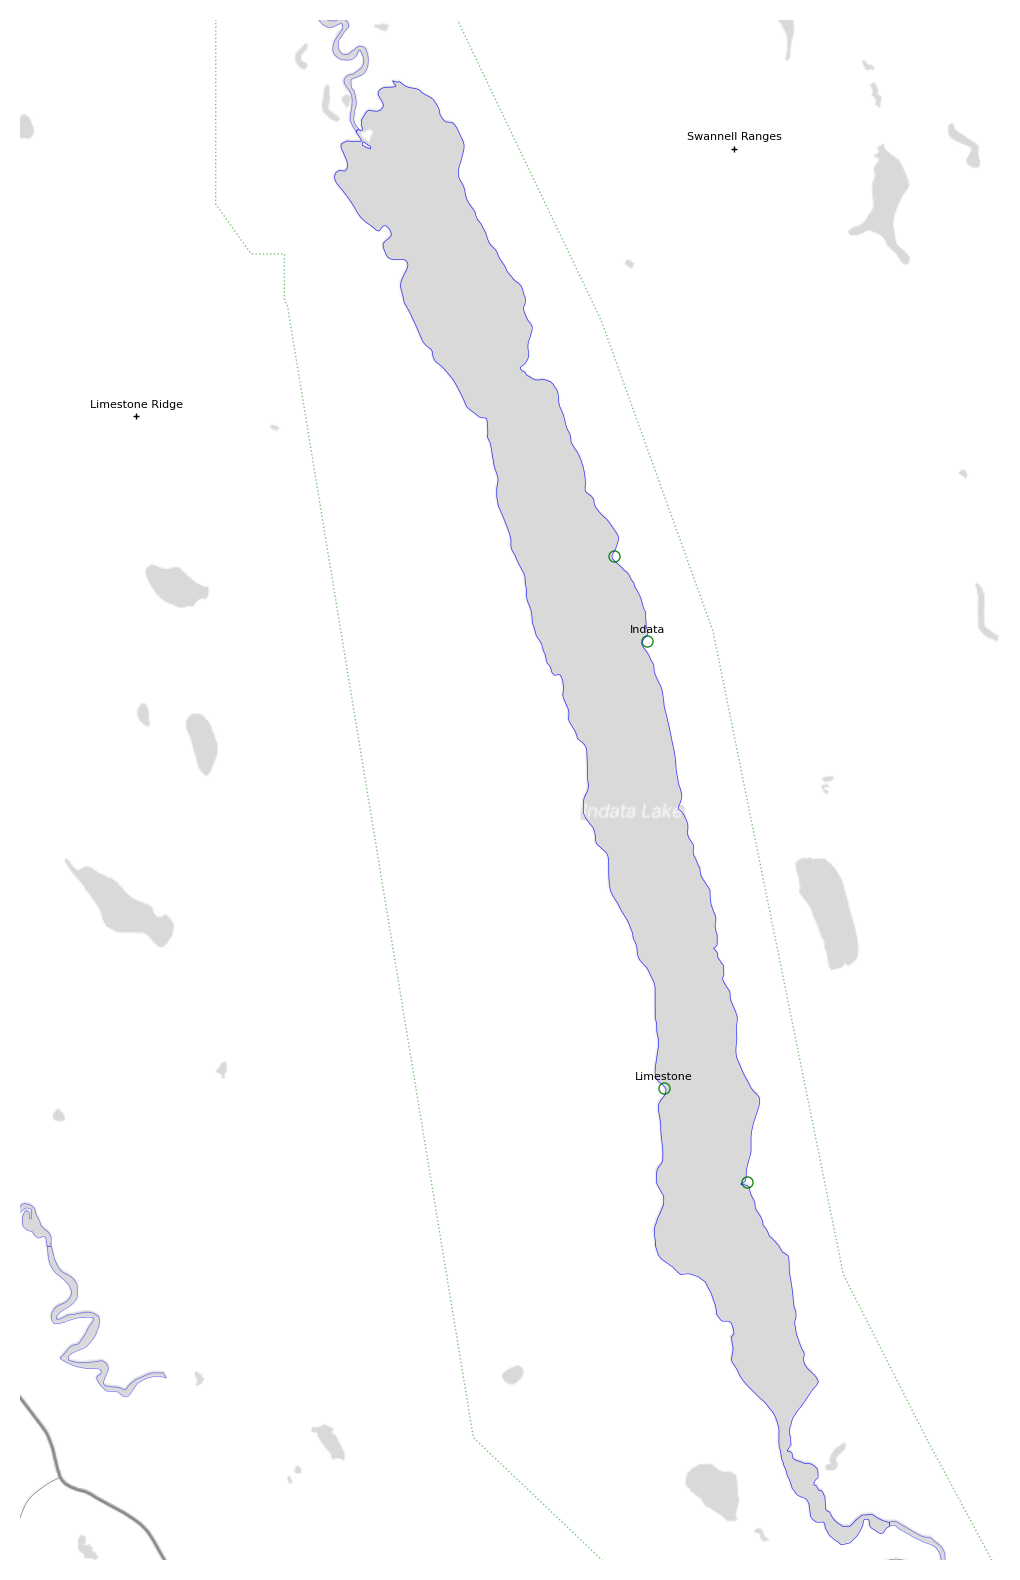

In [21]:
# make fig with backgound tiles
fig,ax = plt.subplots(1, figsize=figsize)
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))
fig.set_dpi(200)
ax.set_axis_off() # don't display axes with coordinates

cx.add_basemap(ax, source=f"{place_name}.tif", zoom=zoom_level);

for element in elements:
    # get coordinates to plot for this element
    element_type = element["element_type"]
    coords_list = extract_coords(element["geometry"])
    for coords in coords_list:
        x,y = zip(*coords)
        ax.plot(x,y,**get_style(element, tag_styles, styles))
    if (element_type == "node" and type(element["name"])!=float):
        ax.annotate(element["name"], (x[0],y[0]), 
                    size=annotation_text_size, 
                    xycoords='data', 
                    xytext=(0, node_marker_size*0.75), 
                    textcoords='offset points', 
                    ha='center')
# plt.savefig('figure.png') 
# plt.show()
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

In [22]:
# add scale bar
scale_width_pct = 0.1 # maximum width of the scale bar as % of map
plot_width_km, plot_heigth_km

(7.146960996189237, 11.188646866275635)

In [23]:
def get_scale_unit(plot_width_km,scale_width_pct):
    scale_units = [1,2,5,10,20,50]
    for scale_unit in scale_units[::-1]:
        scale = plot_width_km * scale_width_pct
        if scale >= scale_unit:
            break
    return scale_unit

In [24]:
dy = y_max - y_min
dx = x_max - x_min

scale_unit = get_scale_unit(plot_width_km,scale_width_pct)
print(f"scale_unit={scale_unit}")
scale_unit_pct = scale_unit / plot_width_km
scale_width = scale_unit_pct * dx
scale_height = dy*0.01
scale_anchor_xy = (x_min + 0.1 * dx , y_min + 0.1 * dy)
scale_anchor_xy

scale_unit=1


(-13950419.436849551, 7420712.168968732)

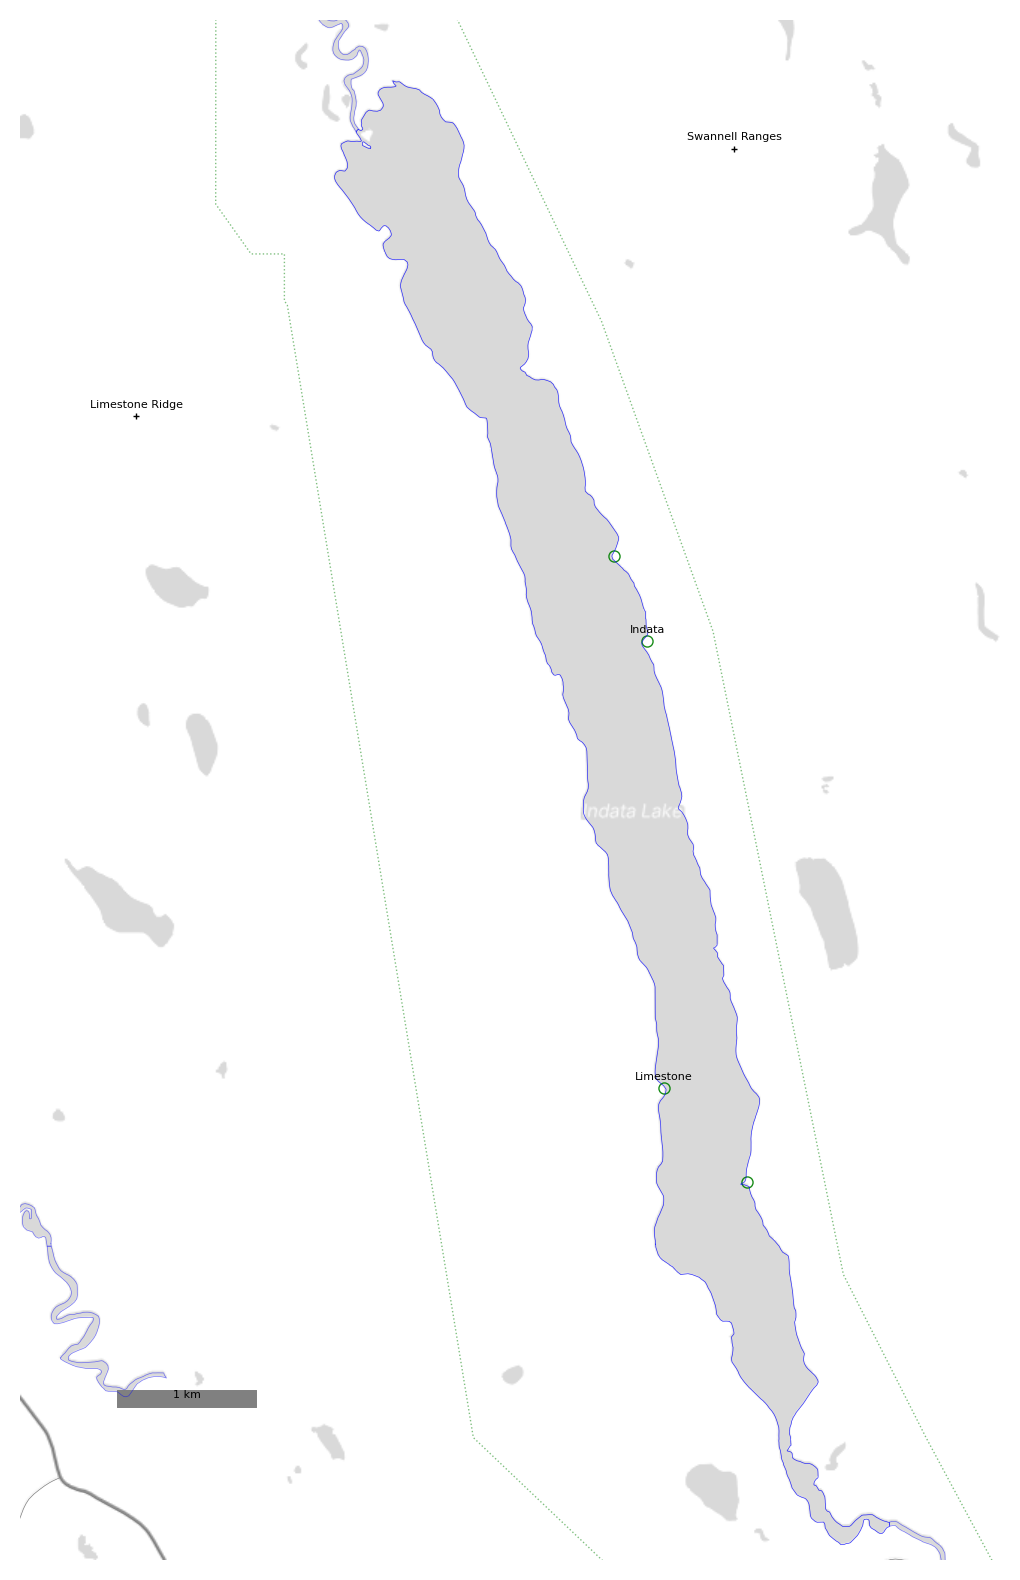

In [25]:
# Create a Rectangle patch
box = patches.Rectangle(scale_anchor_xy, scale_width, scale_height, linewidth=1, edgecolor='grey', facecolor='grey')
ax.add_patch(box)

bar = patches.Rectangle(scale_anchor_xy, scale_width, scale_height, linewidth=1, edgecolor='grey', facecolor='grey')
ax.add_patch(bar)
# Add annotation
ax.annotate(
    f"{scale_unit} km", 
    (scale_anchor_xy[0]+scale_width/2,scale_anchor_xy[1]), 
    size=annotation_text_size, 
    xycoords='data', 
    xytext=(0, node_marker_size*0.75), 
    textcoords='offset points', 
    ha='center')
fig

In [ ]:

styles.keys()

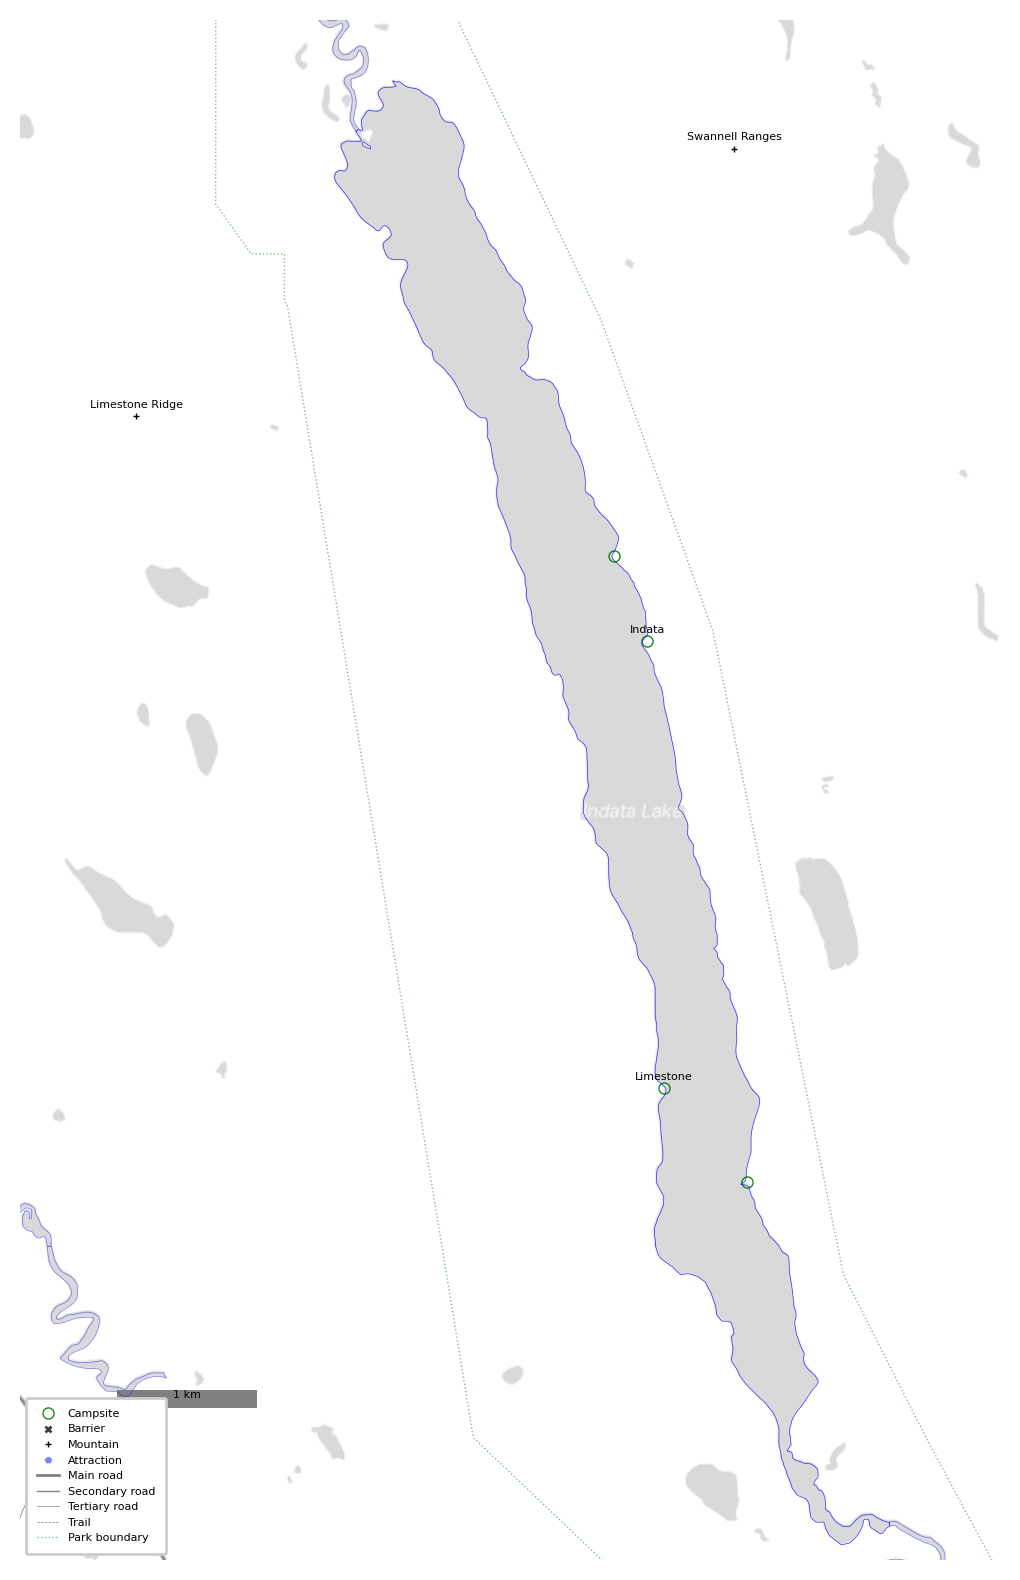

In [26]:
legend_items = {
    'Campsite': styles["campsite"], 
    'Barrier': styles["barrier"], 
    'Mountain': styles["mountain"], 
    'Attraction': styles["attraction"], 
    'Main road': styles["main_road"], 
    'Secondary road': styles["secondary_road"], 
    'Tertiary road': styles["tertiary_road"], 
    'Trail': styles["trail"], 
    'Park boundary': styles["park"], 
}


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Line2D([0], [0], label=key, **value) for key, value in legend_items.items()]

# Create the figure
ax.legend(handles=legend_elements, loc='lower left',fontsize=annotation_text_size,borderpad=1,framealpha=1,
          )

fig
    